# Bayesian Marketing Mix Model
https://github.com/sibylhe/mmm_stan?tab=readme-ov-file

In [81]:
import os
import pandas as pd
import numpy as np
import seaborn as sns                           # for the heatmap
from IPython.display import Image               # for image load
from sklearn.metrics import mean_absolute_error # forecast prediction in the control model

In [2]:
path = "/Applications/Diego Alejandro/2024_1/HP/"
os.chdir(path)

# Data Reading

In [3]:
data = pd.read_excel('DMR_case_study_data.xlsx')

### number of missing values per column

In [4]:
data.isnull().sum()

Date                   0
ProductID              0
UnitSales              0
AvgSellingPrice        0
SearchImpressions      0
SearchClicks           0
DisplayImpressions    14
DisplayClicks          0
RadioSpots             0
DailySiteVisits        0
PagesperVisit          0
BounceRate             0
dtype: int64

Since all the Nan values are in the variable column DisplayImpressions, meaning that the 'Total <font color='red'>paid</font> search impressions delivered daily' was not registered, a simple naive approach this time with not much context will be putting 0 as the total paid. 

In [5]:
data.fillna(0,inplace=True)

In [6]:
data.isnull().sum()

Date                  0
ProductID             0
UnitSales             0
AvgSellingPrice       0
SearchImpressions     0
SearchClicks          0
DisplayImpressions    0
DisplayClicks         0
RadioSpots            0
DailySiteVisits       0
PagesperVisit         0
BounceRate            0
dtype: int64

In [7]:
data.shape

(7013, 12)

We have 12 variables in total and 7013 observations.

# Identification

- Unit Sales := 'Total daily product sales for each Product ID'

- Average Sales Price := 'Average selling price for the units sold'

# Media Channels' impressions (spending)

- Search Impressions := 'Total <font color='red'>paid</font> search impressions delivered daily'

- Search Clicks := 'Total <font color='red'>paid</font> search clicks delivered daily'

- Display Impressions := 'Total <font color='red'>paid</font> display impressions delivered daily'

- Display Clicks := 'Total <font color='red'>paid</font> display clicks delivered daily'

# Control Variables

- Radio Spots := 'Total campaign radio ad spots daily'

- Daily site visits := 'Total visits to the website'

- Pages per visit := 'Average pages viewed per visit'

- Bounce rate := 'Rate at which consumers left the website after a single page view'

# Preparing data

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [10]:
spark = SparkSession \
    .builder \
    .appName("HP_Marketing") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [11]:
sparkDF=spark.createDataFrame(data) # From pandas df to pyspark df

In [12]:
sparkDF.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- ProductID: string (nullable = true)
 |-- UnitSales: long (nullable = true)
 |-- AvgSellingPrice: double (nullable = true)
 |-- SearchImpressions: long (nullable = true)
 |-- SearchClicks: long (nullable = true)
 |-- DisplayImpressions: double (nullable = true)
 |-- DisplayClicks: long (nullable = true)
 |-- RadioSpots: double (nullable = true)
 |-- DailySiteVisits: double (nullable = true)
 |-- PagesperVisit: double (nullable = true)
 |-- BounceRate: double (nullable = true)



In [13]:
sparkDF.show(3)

+-------------------+---------+---------+----------------+-----------------+------------+------------------+-------------+----------+---------------+----------------+-----------------+
|               Date|ProductID|UnitSales| AvgSellingPrice|SearchImpressions|SearchClicks|DisplayImpressions|DisplayClicks|RadioSpots|DailySiteVisits|   PagesperVisit|       BounceRate|
+-------------------+---------+---------+----------------+-----------------+------------+------------------+-------------+----------+---------------+----------------+-----------------+
|2019-08-02 00:00:00|      300|      230|26.9058493081626|             3906|          67|              10.0|            0|       0.0|1139441.9118279|4.50002009141716|0.475408706149982|
|2019-08-02 00:00:00|      301|     1712|22.7849234042638|            16420|         495|              10.0|            0|       0.0|1139441.9118279|4.50002009141716|0.475408706149982|
|2019-08-02 00:00:00|      302|     1442| 20.954666909623|            14598

In [14]:
sparkDF.createOrReplaceTempView("data_")
# this is gonna be the name of the table inside the SQL syntax for a query

# Data for ProductId - 300

In [15]:
q1 = "SELECT SUBSTRING(Date, 1, 10) AS Date, "\
     "ROUND(UnitSales,2) AS sales, "\
     "ROUND(AvgSellingPrice,2) AS AvgSP, "\
     "ROUND(SearchImpressions,2) AS SearImp, "\
     "ROUND(SearchClicks,2) AS SearCli, "\
     "ROUND(DisplayImpressions,2) AS DispImp, "\
     "ROUND(DisplayClicks,2) AS DispCli, "\
     "ROUND(RadioSpots,2) AS Radio, "\
     "ROUND(DailySiteVisits,2) AS DailySV, "\
     "ROUND(PagesperVisit,2) AS Pages_pv, "\
     "ROUND(BounceRate,2) AS BounceR "\
     "FROM data_ WHERE ProductId = 300;"
p_300 = spark.sql(q1)

In [16]:
p_300.show(3)

+----------+-----+-----+-------+-------+-------+-------+-----+----------+--------+-------+
|      Date|sales|AvgSP|SearImp|SearCli|DispImp|DispCli|Radio|   DailySV|Pages_pv|BounceR|
+----------+-----+-----+-------+-------+-------+-------+-----+----------+--------+-------+
|2019-08-02|  230|26.91|   3906|     67|   10.0|      0|  0.0|1139441.91|     4.5|   0.48|
|2019-08-03|  176|25.76|   3611|     46|   15.0|      0|  0.0|1178689.64|     4.0|   0.51|
|2019-08-04|  208|26.23|   4700|     67|   13.0|      0|  0.0|1217203.92|    3.93|   0.51|
+----------+-----+-----+-------+-------+-------+-------+-----+----------+--------+-------+
only showing top 3 rows



In [17]:
p_300.count()

344

In [18]:
df_p300 = p_300.toPandas()
df_p300.head(5)

Date  sales  AvgSP  SearImp  SearCli  DispImp  DispCli  Radio  \
0  2019-08-02    230  26.91     3906       67     10.0        0    0.0   
1  2019-08-03    176  25.76     3611       46     15.0        0    0.0   
2  2019-08-04    208  26.23     4700       67     13.0        0    0.0   
3  2019-08-05    186  27.05     5015       66     16.0        0    0.0   
4  2019-08-06    272  26.42     4882       93     10.0        0    0.0   

      DailySV  Pages_pv  BounceR  
0  1139441.91      4.50     0.48  
1  1178689.64      4.00     0.51  
2  1217203.92      3.93     0.51  
3  1263040.50      4.88     0.49  
4  1316645.09      4.59     0.50

In [19]:
df_p300.dtypes

Date         object
sales         int64
AvgSP       float64
SearImp       int64
SearCli       int64
DispImp     float64
DispCli       int64
Radio       float64
DailySV     float64
Pages_pv    float64
BounceR     float64
dtype: object

# Exploratory Data Analysis

In [20]:
corr_ = df_p300.corr()

<AxesSubplot:>

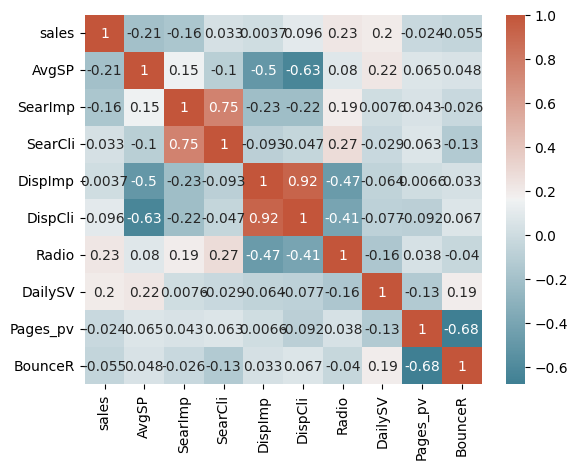

In [21]:
sns.heatmap(corr_, xticklabels = corr_.columns, yticklabels = corr_.columns, annot = True, cmap = sns.diverging_palette(220, 20, as_cmap=True))

- Radio and Daily site visits slightly correlate positively with Sales.

- Average Sale Price and Search impressions slightly correlate negatively with Sales.

&ensp;

- Search Click and <font color='blue'>Search Impressions</font> highly correlate with each other.

- <ins>Display Click</ins> and <font color='purple'>Display Impressions</font> highly correlate with each other.
- <font color='green'>Pages per visit</font> and Bounce Rate higly correlate negatively with each other.
- <font color='red'>Average sale price</font> and <ins>Display Click</ins> higly correlate negatively with each other.

In order to avoid multicolinearity, one of them should be chosen. Let's say,

## Media Channels' impressions (spending)
- Search Impressions
- Display Impressions

## Control Variables
- Pages per visit
- Average sale price
- Radio
- Daily site visits

# The model is built in a stacked way.

In [41]:
Image(url="model.png", width=800, height=100)

# Three models are trained:   
# - 1) Control Model
# - 2) Marketing Mix Model
# - 3) Diminishing Return Model    

Media mix models are used by advertisers to measure the effectiveness of their advertising and provide insight in making future budget allocation decisions.

<ins>Why would this approach be better than a frequentist one </ins>?:

The model is estimated using a Bayesian approach in order to make use of prior knowledge accumulated in previous or related media mix models

# <font color='purple'>Shape Effect</font>
the response of sales to a media variable is assumed linear. Such a linear response curve is not able to account for ad saturation and diminishing returns at high levels of spend, referred to as the shape effect in Tellis

Advertising usually has lag effects and diminishing returns, which are hard to capture using linear regression.

- This is why model 1 using multiple regression has its problems.

# <font color='purple'>Lag/Carryover Effect</font>
It is widely believed that advertising has a lag or carryover effect

This may be due to delayed consumer response, delayed purchase due to consumers’ inventory, or purchases from consumers who have heard from those who first saw the ad.

This media mix model has a flexible functional form to model the carryover and shape effects of advertising.

# Model Specification

- Suppose we have weekly national level data for weeks from $t = 1,...,T$.
- There are $M$ media channels in the media mix, and $x_t$,m is the media spend of channel m at week t.
- There are non-media variables as control variables and use $z_{t,c}$ to denote the value of the c-th control variable at week t.

# <font color='purple'>Carryover mitigation</font>

To model the carryover effect of advertising, we transform the time series of media spend in one channel through the adstock function:

$$adstock(x_{t-L+1,m}, ... , x_{t,m} ; w_m , L) = \frac{\sum_{l=0}^{L-1}w_m(l) x_{t-l,m} }{\sum_{l=0}^{L-1} w_m(l)}$$

where $w_m$ is a nonnegative weight function

The cumulative media effect is a weighted average of media spend in the current week and previous L − 1 weeks.

L is the maximum duration of carryover effect assumed for a medium. (If there is no such prior information about L, it can be set to a very large number)

We can use different functional forms for the weight function $w_m$. A commonly used function is

<ins> geometric decay </ins>:

$$w^g_m (l;\alpha_m) = \alpha^l_m$$

$l = 0,...,L-1, 0<\alpha_m<1$

Where $\alpha_m$ is the <ins> retention </ins> rate of ad effect of the $m-th$ media from one period to the next.

Adstock with geometric decay assumes advertising effect <ins> peaks </ins> at the same time period as ad exposure

To account for a delay in the peak effect, we introduce the delayed adstock function wd, as

$$w^d_m(l;\alpha_m,\theta_m) = \alpha_m^{(l-\theta_m)^2}$$

$l = 0,...,L-1, 0<\alpha_m<1, 0\leq \theta_m \leq L-1$, where $\theta_m$ is the delay of the peak effect.

Method apply_adstock implements the adstock function we just mention to model the carryover effect of advertising.

In [22]:
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
#         xi = sum(x_array * weights)/sum(weights)
        xi = (x_array * weights).sum()/(weights).sum()
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

This following method takes the original dataframe and gives you back the transformed dataframe by the adstock function. So each column gets the transformation for counting for the carryover effect of advertising.

In [23]:
def adstock_transform(df, md_cols, adstock_params):
    '''
    params:
    df: original data
    md_cols: list, media variables to be transformed
    adstock_params: dict, 
        e.g., {'sem': {'L': 8, 'P': 0, 'D': 0.1}, 'dm': {'L': 4, 'P': 1, 'D': 0.7}}
    returns: 
    adstocked df
    '''
    md_df = pd.DataFrame()
    for md_col in md_cols:
        md = md_col.split('_')[-1]
        L, P, D = adstock_params[md]['L'], adstock_params[md]['P'], adstock_params[md]['D']
        xa = apply_adstock(df[md_col].values, L, P, D)
        md_df[md_col] = xa
    return md_df

# <font color='purple'>Shape Mitigation</font>

To model the shape effect of advertising, the media spend needs to be transformed through a curvature function.

A candidate for such a curvature functoin is the Hill function:

$$Hill(x_{t,m}; K_m,S_m) = \frac{1}{1 + \left[\frac{x_{t,m}}{K_m}\right]^{-S_m} }$$

, $x_{t,m} \geq 0$, where $S_m>0$ is the shape parameter which is also referred to as slope, and $K_m>0$ is the half saturation point, because $Hill(K_m) = \frac{1}{2}$ for any value of $K_m$ and $S_m$. As $x$ goes to infinity, the Hill function approaches to 1.

In [24]:
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope))

Let $y_t$ be the response variable at week t, which could be sales or log transformed sales. The response can be modeled by the following generic equation:

$$y_t = \tau + \sum^{M}_{m=1} \beta_m Hill(x^{*};K_m,S_m) + \sum_{c=1}^C \gamma_c z_{t,c} + \epsilon_t$$

where $x^{*}_{t,m} = adstock(x_{t-L+1,m} , ... , x_{t,m}; w_m, L)$

$\tau$ is the baseline sales

$\gamma_c$ is the effect of control variable $z_c$ and 

$\epsilon_t$ is some white noise that is assumed to be uncorrelated with the other variables in the model and to have constant variance.

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

def mean_center_trandform(df, cols):
    '''
    returns: 
    mean-centered df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

def mean_log1p_trandform(df, cols):
    '''
    returns: 
    mean-centered, log1p transformed df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

# 1) Control Model / Base Sales Model

Goal: predict base sales (X_ctrl) as an input variable to MMM, this represents the baseline sales trend without any marketing activities.

In [27]:
import pystan
import os

In [49]:
list(p_300.columns)

['Date',
 'sales',
 'AvgSP',
 'SearImp',
 'SearCli',
 'DispImp',
 'DispCli',
 'Radio',
 'DailySV',
 'Pages_pv',
 'BounceR']

In [46]:
# 1. media variables
# media impression
mdip_cols = ['SearImp','DispImp'] #['SearImp','DispImp','SearCli','DispCli']
# media spending
mdsp_cols = [] #['SearCli','DispCli']

# 2. control variables
# macro economics variables
me_cols = []                  # there are no macroeconomic variables
# store count variables
st_cols = ['Radio','DailySV','Pages_pv']#['AvgSP','Radio','DailySV','Pages_pv','BounceR']
# markdown/discount variables
mrkdn_cols = []               # there are no discount variables
# holiday variables
hldy_cols = []                # there are no holiday variables
# seasonality variables
seas_cols = ['AvgSP']         # average sale price will depend on the season I think.

base_vars = me_cols + st_cols + mrkdn_cols + hldy_cols + seas_cols

# 3. sales variables
sales_cols =['sales']

In [47]:
# mean-centralize: sales, numeric base_vars
df = df_p300
df_ctrl, sc_ctrl = mean_center_trandform(df, ['sales']+me_cols+st_cols+mrkdn_cols)
df_ctrl = pd.concat([df_ctrl, df[hldy_cols+seas_cols]], axis=1)

In [48]:
# variables POSITIVELY related to sales: macro economy, store count, markdown, holiday
pos_vars = [col for col in base_vars if col not in seas_cols]

In [49]:
pos_vars

['Radio', 'DailySV', 'Pages_pv']

In [50]:
X1 = df_ctrl[pos_vars].values

# variables may have EITHER positive or negtive impact on sales: seasonality
pn_vars = seas_cols
X2 = df_ctrl[pn_vars].values

In [51]:
X1

array([[0.        , 0.89413864, 1.01488232],
       [0.        , 0.92493698, 0.90211762],
       [0.        , 0.95515976, 0.88633056],
       ...,
       [0.        , 0.96929263, 1.10509408],
       [0.        , 0.95339055, 1.1366682 ],
       [0.        , 0.87673374, 1.08930702]])

In [52]:
X2

array([[26.91],
       [25.76],
       [26.23],
       [27.05],
       [26.42],
       [26.69],
       [25.2 ],
       [24.36],
       [23.99],
       [26.68],
       [28.28],
       [30.52],
       [29.85],
       [27.92],
       [27.66],
       [27.54],
       [27.66],
       [26.61],
       [29.86],
       [28.66],
       [27.57],
       [27.5 ],
       [26.79],
       [27.82],
       [27.1 ],
       [27.99],
       [29.01],
       [28.12],
       [28.13],
       [26.85],
       [28.17],
       [26.93],
       [27.48],
       [26.58],
       [21.22],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.28],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [ 0.28],
       [ 0.28],
       [ 0.28],
       [ 0.28],
       [ 0.27],
       [ 0.26],
       [ 0.27],
       [ 0.27],
       [ 0.27],
       [

In [53]:
max_intercept = df_ctrl['sales'].min()

In [54]:
print(f'N: {len(df_ctrl)} \nK1: {len(pos_vars)} \nK2: {len(pn_vars)} \nmaxintercept: { max_intercept }')

N: 344 
K1: 3 
K2: 1 
maxintercept: 0.09689396461219368


In [55]:
ctrl_data = {
    'N': len(df_ctrl),
    'K1': len(pos_vars), 
    'K2': len(pn_vars), 
    'X1': X1,
    'X2': X2, 
    'y': df_ctrl['sales'].values,
    'max_intercept': max_intercept
}

In [56]:
ctrl_code1 = '''
data {
  int N;                // number of observations
  int K1;               // number of positive predictors
  int K2;               // number of positive/negative predictors
  real max_intercept;   // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y; 
}

parameters {
  vector<lower=0>[K1] beta1;                 // regression coefficients for X1 (positive)
  vector[K2] beta2;                          // regression coefficients for X2 (either negative or positive)
  real<lower=0, upper=max_intercept> alpha;  // intercept
  real<lower=0> noise_var;                   // residual variance
}

model {
  // Define the priors
  
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
  
  // y ~ normal(X1*beta1 + alpha, sqrt(noise_var));
}
'''

In [57]:
sm1 = pystan.StanModel(model_code=ctrl_code1, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a NOW.
INFO:pystan:OS: darwin, Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:59:23) 
[Clang 11.1.0 ], Cython 3.0.8


Compiling /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.pyx because it changed.
[1/1] Cythonizing /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.pyx


INFO:root:building 'stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203' extension
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/var
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/var/folders
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/var/folders/3y
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9
INFO:root:x86_64-apple-darwin13.4.0-clang -fno-strict-aliasing -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O3 -Wall -Wstrict-prototypes -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1287:
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan_fit.hpp:841:12: warning: 'auto_ptr<stan::io::var_context>' is deprecated [-Wdeprecated-declarations]
      std::auto_ptr<stan::io::var_context> init_context_ptr;
           ^
/Users/dportelacassab/anaconda3/envs/myenv/bin/../include/c++/v1/__memory/auto_ptr.h:30:28: note: 'auto_ptr<stan::io::var_context>' has been explicitly marked deprecated here
class _LIBCPP_TEMPLATE_VIS _LIBCPP_DEPRECATED_IN_CXX11 auto_ptr
                           ^
/Users/dportelacassab/anaconda3/envs/myenv/bin/../include/c++/v1/__config:862:41: note: expanded from macro '_LIBCPP_DEPRECATED_IN_CXX11'
#    define _LIBCPP_DEPRECATED_IN_CXX11 _LIBCPP_DEPRECATED
                                        ^
/Users/dportelacassab/anaconda3/envs/myenv/bin/../include/c++/v1/_

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/PlainObjectBase.h:710:17: note: in instantiation of function template specialization 'Eigen::internal::call_assignment<Eigen::Matrix<double, -1, 1, 0>, Eigen::CwiseBinaryOp<Eigen::internal::scalar_quotient_op<double>, const Eigen::Product<Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, -1, -1, 0>>, const Eigen::Matrix<double, -1, -1, 0>>, Eigen::Matrix<double, -1, 1, 0>, 0>, const Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, const Eigen::Matrix<double, -1, 1, 0>>>>' requested here
      internal::call_assignment(this->derived(), other.derived());
                ^
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/Matrix.h:225:20: note: in instant

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan

  typedef typename AssignmentTraits::PacketType PacketType;
                   ^
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:739:10: note: in instantiation of template class 'Eigen::internal::generic_dense_assignment_kernel<Eigen::internal::evaluator<Eigen::Diagonal<Eigen::Block<Eigen::Matrix<double, -1, -1, 0>, -1, -1, false>, 0>>, Eigen::internal::evaluator<Eigen::CwiseNullaryOp<Eigen::internal::scalar_constant_op<double>, Eigen::Matrix<double, -1, 1, 0>>>, Eigen::internal::mul_assign_op<double>, 0>' requested here
  Kernel kernel(dstEvaluator, srcEvaluator, func, dst.const_cast_derived());
         ^
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:879:5: note: in instantiation of function template specialization 'Eigen::internal::call_dense_assignment_loop<Eigen::Diagonal<Eigen::Block<E

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

      Base::template _init1<T>(x);
                     ^
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/variational/families/normal_fullrank.hpp:189:32: note: in instantiation of function template specialization 'Eigen::Matrix<double, -1, 1, 0>::Matrix<Eigen::CwiseUnaryOp<Eigen::internal::scalar_square_op<double>, const Eigen::ArrayWrapper<const Eigen::Matrix<double, -1, 1, 0>>>>' requested here
        return normal_fullrank(Eigen::VectorXd(mu_.array().square()),
                               ^
In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dp

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

            = stan::services::optimize::bfgs(model, *init_context_ptr,
                                        ^
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan_fit.hpp:1649:15: note: in instantiation of function template specialization 'pystan::(anonymous namespace)::command<anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_namespace::anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a, boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399>>>' requested here
        ret = command(args, model_, holder, names_oi_tidx_,
              ^
/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:16215:33: note: in instantiation of member function 'pystan::stan_fit<anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_namespace::anon_model_f9cc65a686ca9eac6de3c

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/stanfit4anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a_6136664394259344203.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

194 warnings generated.
INFO:root:x86_64-apple-darwin13.4.0-clang++ -bundle -undefined dynamic_lookup -Wl,-pie -Wl,-headerpad_max_install_names -Wl,-dead_strip_dylibs -Wl,-rpath,/Users/dportelacassab/anaconda3/envs/myenv/lib -L/Users/dportelacassab/anaconda3/envs/myenv/lib -flto -Wl,-export_dynamic -Wl,-pie -Wl,-headerpad_max_install_names -Wl,-dead_strip_dylibs -Wl,-rpath,/Users/dportelacassab/anaconda3/envs/myenv/lib -L/Users/dportelacassab/anaconda3/envs/myenv/lib -Wl,-pie -Wl,-headerpad_max_install_names -Wl,-dead_strip_dylibs -Wl,-rpath,/Users/dportelacassab/anaconda3/envs/myenv/lib -L/Users/dportelacassab/anaconda3/envs/myenv/lib -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O2 -pipe -isystem /Users/dportelacassab/anaconda3/envs/myenv/include -D_FORTIFY_SOURCE=2 -isystem /Users/dportelacassab/anaconda3/envs/myenv/include /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_7ju8emh9/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pys

In [58]:
fit1 = sm1.sampling(data=ctrl_data, iter=2000, chains=4)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in 'unknown file name' at line 26)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is nan, but must be finite!  (in 'unknown file name' at line 26)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-co


Gradient evaluation took 0.000259 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.59 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.00026 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00022 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.2 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000171 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.71 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%

INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection


Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 2.09615 seconds (Warm-up)
               0.796018 seconds (Sampling)
               2.89217 seconds (Total)

Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 2.29789 seconds (Warm-up)
               0.709759 seconds (Sampling)
               3.00765 seconds (Total)



In [59]:
print(fit1.stansummary())

Inference for Stan model: anon_model_f9cc65a686ca9eac6de3c0a1a74bc77a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1[1]    0.09  3.4e-4   0.02   0.06   0.08   0.09   0.11   0.13   2491    1.0
beta1[2]    1.28  3.2e-3   0.13   1.02    1.2   1.29   1.37   1.53   1597    1.0
beta1[3]    0.11  2.5e-3   0.09 3.7e-3   0.04   0.09   0.16   0.33   1229    1.0
beta2[1]   -0.02  5.8e-5 3.2e-3  -0.03  -0.02  -0.02  -0.02  -0.01   3140    1.0
alpha       0.04  5.2e-4   0.03 1.7e-3   0.02   0.04   0.07   0.09   2882    1.0
noise_var   0.31  4.6e-4   0.02   0.27    0.3   0.31   0.33   0.36   2784    1.0
lp__       18.67    0.04   1.82  14.33  17.68  19.01  19.99  21.22   1671    1.0

Samples were drawn using NUTS at Wed Feb 21 15:38:58 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale 

In [62]:
print(pos_vars)
print(pn_vars)

['Radio', 'DailySV', 'Pages_pv']
['AvgSP']


## Interpretation of the beta parameters

- $\beta_1$ := 'the increment of one unit in the total campaign radio ad spots daily and setting all other variables fixed imply a 0.09 increment rate in sales on average'
- $\beta_2$ := 'the increment of one unit in the total visits to the website and setting all other variables fixed imply a 1.28 increment rate in sales on average'
- $\beta_3$ := 'the increment of one unit in the average pages viewed per visit and setting all other variables fixed imply a 0.11 increment rate in sales on average'
- $\beta_4$ := 'the increment of one unit in the Average selling price for the units sold and setting all other variables fixed imply a 0.02 decrement rate in sales on average'
- $\beta_0$ := 'slope - sales grow on a baseline with a rate of 0.04 on average'

In [63]:
fit1_result = fit1.extract()

In [64]:
# extract control model parameters and predict base sales -> df['base_sales']
def extract_ctrl_model(fit_result, pos_vars=pos_vars, pn_vars=pn_vars, 
                       extract_param_list=False):
    ctrl_model = {}
    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
#     ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
#         ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    pos_vars, pn_vars = ctrl_model['pos_vars'], ctrl_model['pn_vars'] 
    X1 = df[pos_vars]
#     X2 = df[pn_vars]
    beta1 = np.array(ctrl_model['beta1'])
#     beta2 = np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
#     y_pred = np.dot(X1, beta1) + np.dot(X2, beta2) + alpha
    y_pred = np.dot(X1, beta1) + alpha
    return y_pred

Extract control model parameters from the fit object and predict base sales -> df['base_sales']

In [ ]:
base_sales_model = extract_ctrl_model(fit1_result, pos_vars=pos_vars, pn_vars=pn_vars)
base_sales = ctrl_model_predict(base_sales_model, df_ctrl)
df['base_sales'] = base_sales*sc_ctrl['sales']

In [65]:
# evaluate the control model (Forecast accuracy betwen the sales and the base sales)
print('mape: ', mean_absolute_percentage_error(df['sales'], df['base_sales']))

mape:  153.124406753022


In [67]:
mean_absolute_error(df['sales'], df['base_sales'])

146.0064801915461

These key performance indicators (KPI's) does not look the best they are high, at least for the mean absolute error where the best value would be 0. However, to say if we want to say good or bad we need to compare it to another model and see which one is best. But so far, it does not seem to be good.

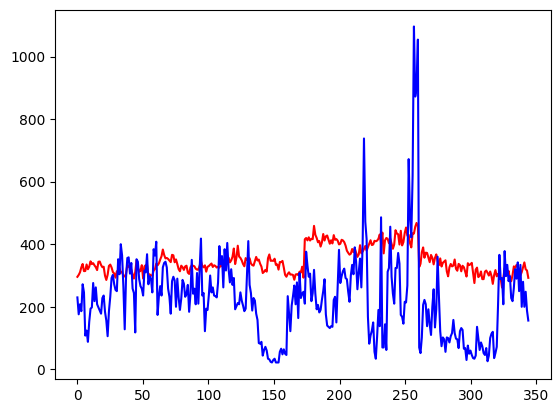

In [80]:
import matplotlib.pyplot as plt
from numpy import *

t = linspace(0, len(df['base_sales']),len(df['base_sales']))
plt.plot(t, df['base_sales'], 'r') # plotting t, a separately 
plt.plot(t, df['sales'], 'b') # plotting t, b separately 
plt.show()

From this plot we can see base sales prediction are not that close to the real sales.
Let's continue with the analysis.

In [ ]:
# np.savetxt("base_sales_pred.csv", df['base_sales'].values, delimiter=",")
# save_json(base_sales_model, 'ctrl_model.json')
# df['base_sales'] = pd.read_csv('base_sales_pred.csv', header=None).values

# 2) Marketing Mix Model

Goal:

- Find appropriate adstock parameters for media channels.
- Decompose sales to media channels' contribution (and non-marketing contribution).

In [82]:
df.head()

Date  sales  AvgSP  SearImp  SearCli  DispImp  DispCli  Radio  \
0  2019-08-02    230  26.91     3906       67     10.0        0    0.0   
1  2019-08-03    176  25.76     3611       46     15.0        0    0.0   
2  2019-08-04    208  26.23     4700       67     13.0        0    0.0   
3  2019-08-05    186  27.05     5015       66     16.0        0    0.0   
4  2019-08-06    272  26.42     4882       93     10.0        0    0.0   

      DailySV  Pages_pv  BounceR  base_sales  
0  1139441.91      4.50     0.48  295.791184  
1  1178689.64      4.00     0.51  301.967965  
2  1217203.92      3.93     0.51  310.385483  
3  1263040.50      4.88     0.49  326.191066  
4  1316645.09      4.59     0.50  336.828023

In [83]:
df_mmm, sc_mmm = mean_log1p_trandform(df, ['sales', 'base_sales'])

In [84]:
mu_mdip = df[mdip_cols].apply(np.mean, axis=0).values
max_lag = 8
num_media = len(mdip_cols)

In [85]:
# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df[mdip_cols].values), axis=0)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df),1)

In [94]:
print(f'X_media: {(X_media.shape)} \nXctrl: {X_ctrl.shape}')

X_media: (351, 2) 
Xctrl: (344, 1)


In [86]:
print(f'N: {len(df)} \nmax_lag: {max_lag} \nnum_media: {num_media} \nmu_mdip: {mu_mdip} \nnum_ctrl: {X_ctrl.shape[1]} ')

N: 344 
max_lag: 8 
num_media: 2 
mu_mdip: [  8137.29651163 711809.75      ] 
num_ctrl: 1 


In [96]:
model_data2 = {
    'N': len(df),
    'max_lag': max_lag, 
    'num_media': num_media,
    'X_media': X_media, 
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['sales'].values
}

In [98]:
Image(url="modelSpec.png", width=800, height=100)

In [106]:
model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  
  int N;                                    // the total number of observations
  real y[N];                                // the vector of sales
  int max_lag;                              // the maximum duration of lag effect, in weeks
  int num_media;                            // the number of media channels
  matrix[N+max_lag-1, num_media] X_media;   // matrix of media variables
  real mu_mdip[num_media];                  // vector of media variables' mean
  int num_ctrl;                             // the number of other control variables
  matrix[N, num_ctrl] X_ctrl;               // a matrix of control variables
}
parameters {
  real noise_var;                                    // residual variance
  real<lower=0> tau;                                 // the intercept
  vector<lower=0>[num_media+num_ctrl] beta;  //,upper=1 the coefficients for media variables and base sales

  // the decay and peak parameter for the adstock transformation of each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0>[num_media] peak;
}
transformed parameters {
  real cum_effect;                         // the cumulative media effect after adstock
  matrix[N, num_media] X_media_adstocked;  // matrix of media variables after adstock
  matrix[N, num_media+num_ctrl] X;         // matrix of all predictors
  
  row_vector[max_lag] lag_weights;   // adstock, mean-center, log1p transformation
  for (nn in 1:N) {
    for (media in 1 : num_media) {
    
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] = pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
      cum_effect = Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
      X_media_adstocked[nn, media] = log1p(cum_effect/mu_mdip[media]);
      
    }
    X = append_col(X_media_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''

# Prior Specification

| Parameter | Prior |description|
| --- | --- | --- |
| $\alpha$ | beta(3,3) | retention rate adstock function |
| $\theta$ | uniform(0,12) | delay parameter adstock function |
|K|gamma(3,1)| Half saturation point Hill function |
|S|gamma(3,1)| Shape parameter(slope) Hill function |
|$\beta$|half normal(0,1)| regression coefficients of the media variables |
|$\tau$|normal(0,5)| intercept(baseline sales) |
|$\gamma$|normal(0,1)| regression coefficients of the control variables |
|Var($\epsilon$)|inverse gamma(0.05,0.0005)| Var of the white noise |

In [107]:
sm2 = pystan.StanModel(model_code=model_code2, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_512e38bd3182ad75c6666e371305fae5 NOW.
DIAGNOSTIC(S) FROM PARSER:
Info: integer division implicitly rounds to integer. Found int division: max_lag / 2
 Positive values rounded down, negative values rounded up or down in platform-dependent way.

INFO:pystan:OS: darwin, Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:59:23) 
[Clang 11.1.0 ], Cython 3.0.8


Compiling /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.pyx because it changed.
[1/1] Cythonizing /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.pyx


INFO:root:building 'stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841' extension
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/var
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/var/folders
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/var/folders/3y
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3
INFO:root:x86_64-apple-darwin13.4.0-clang -fno-strict-aliasing -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O3 -Wall -Wstrict-prototypes -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1287:
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan_fit.hpp:841:12: warning: 'auto_ptr<stan::io::var_context>' is deprecated [-Wdeprecated-declarations]
      std::auto_ptr<stan::io::var_context> init_context_ptr;
           ^
/Users/dportelacassab/anaconda3/envs/myenv/bin/../include/c++/v1/__memory/auto_ptr.h:30:28: note: 'auto_ptr<stan::io::var_context>' has been explicitly marked deprecated here
class _LIBCPP_TEMPLATE_VIS _LIBCPP_DEPRECATED_IN_CXX11 auto_ptr
                           ^
/Users/dportelacassab/anaconda3/envs/myenv/bin/../include/c++/v1/__config:862:41: note: expanded from macro '_LIBCPP_DEPRECATED_IN_CXX11'
#    define _LIBCPP_DEPRECATED_IN_CXX11 _LIBCPP_DEPRECATED
                                        ^
/Users/dportelacassab/anaconda3/envs/myenv/bin/../include/c++/v1/_

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/stanfit4anon_model_512e38bd3182ad75c6666e371305fae5_5862764940418439841.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

196 warnings generated.
INFO:root:x86_64-apple-darwin13.4.0-clang++ -bundle -undefined dynamic_lookup -Wl,-pie -Wl,-headerpad_max_install_names -Wl,-dead_strip_dylibs -Wl,-rpath,/Users/dportelacassab/anaconda3/envs/myenv/lib -L/Users/dportelacassab/anaconda3/envs/myenv/lib -flto -Wl,-export_dynamic -Wl,-pie -Wl,-headerpad_max_install_names -Wl,-dead_strip_dylibs -Wl,-rpath,/Users/dportelacassab/anaconda3/envs/myenv/lib -L/Users/dportelacassab/anaconda3/envs/myenv/lib -Wl,-pie -Wl,-headerpad_max_install_names -Wl,-dead_strip_dylibs -Wl,-rpath,/Users/dportelacassab/anaconda3/envs/myenv/lib -L/Users/dportelacassab/anaconda3/envs/myenv/lib -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O2 -pipe -isystem /Users/dportelacassab/anaconda3/envs/myenv/include -D_FORTIFY_SOURCE=2 -isystem /Users/dportelacassab/anaconda3/envs/myenv/include /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_gpxmb8m3/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pys

In [108]:
fit2 = sm2.sampling(data=model_data2, iter=1000, chains=3)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: multiply: A[1] is nan, but must not be nan!  (in 'unknown file name' at line 55)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: multiply: A[1] is nan, but must not be nan!  (in 'unknown file name' at line 55)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warn


Gradient evaluation took 0.00692 seconds
1000 transitions using 10 leapfrog steps per transition would take 69.2 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 55)


Gradient evaluation took 0.006969 seconds
1000 transitions using 10 leapfrog steps per transition would take 69.69 seconds.
Adjust your expectations accordingly!


Rejecting initial value:
  Log probability evaluates to log(0), i.e. negative infinity.
  Stan can't start sampling from this initial value.

Gradient evaluation took 0.005968 seconds
1000 transitions using 10 leapfrog steps per transition would take 59.68 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 55)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 55)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of 

Iteration: 100 / 1000 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 55)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 55)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of 

Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 55)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 38.4136 seconds (Warm-u

INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [109]:
print(fit2.stansummary())

Inference for Stan model: anon_model_512e38bd3182ad75c6666e371305fae5.
3 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1500.

                           mean se_mean      sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
noise_var                  0.07  5.1e-4  5.2e-3    0.06    0.07   0.07   0.07   0.08    106   1.05
tau                        0.05 10.0e-3    0.04  9.8e-4    0.01   0.04   0.07   0.14     17   1.15
beta[1]                    0.01  1.6e-3 10.0e-3  2.7e-4  3.1e-3 7.9e-3   0.02   0.04     41   1.07
beta[2]                    0.08  4.0e-3    0.03    0.02    0.06   0.08   0.09   0.14     53   1.03
beta[3]                    0.81    0.02    0.07     0.7    0.75   0.83   0.86   0.91     14   1.18
decay[1]                   0.51    0.03    0.19    0.13    0.37   0.52   0.66   0.83     50   1.08
decay[2]                   0.55    0.04    0.19     0.2    0.41   0.56   0.71   0.85     24   1.19
peak[1]              

- High problems with convergence.
- nan values when the estimation of the mean of the track variable X is zero.
- Better understanding and alternative specifications of the model should be done in order to improve this output.

So far, let's work with what we have

In [110]:
fit2_result = fit2.extract()

In [111]:
# extract mmm parameters
def extract_mmm(fit_result, max_lag=max_lag, 
                media_vars=mdip_cols, ctrl_vars=['base_sales'], 
                extract_param_list=True):
    mmm = {}
    
    mmm['max_lag'] = max_lag
    mmm['media_vars'], mmm['ctrl_vars'] = media_vars, ctrl_vars
    mmm['decay'] = decay = fit_result['decay'].mean(axis=0).tolist()
    mmm['peak'] = peak = fit_result['peak'].mean(axis=0).tolist()
    mmm['beta'] = fit_result['beta'].mean(axis=0).tolist()
    mmm['tau'] = fit_result['tau'].mean()
    
    if extract_param_list:
        mmm['decay_list'] = fit_result['decay'].tolist()
        mmm['peak_list'] = fit_result['peak'].tolist()
        mmm['beta_list'] = fit_result['beta'].tolist()
        mmm['tau_list'] = fit_result['tau'].tolist()
    
    adstock_params = {}
    media_names = [col.replace('mdip_', '') for col in media_vars]
    for i in range(len(media_names)):
        adstock_params[media_names[i]] = {
            'L': max_lag,
            'P': peak[i],
            'D': decay[i]
        }
    mmm['adstock_params'] = adstock_params
    return mmm

In [112]:
mmm = extract_mmm(fit2, max_lag=max_lag, media_vars=mdip_cols, ctrl_vars=['base_sales'])
# save_json(mmm, 'mmm1.json')

In [115]:
list(mmm.keys())

['max_lag',
 'media_vars',
 'ctrl_vars',
 'decay',
 'peak',
 'beta',
 'tau',
 'decay_list',
 'peak_list',
 'beta_list',
 'tau_list',
 'adstock_params']

In [121]:
# mmm['beta_list']

In [122]:
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_media[md] = np.array(betas)

In [123]:
len(mmm['media_vars'])
mmm['media_vars']

['SearImp', 'DispImp']

# Plot media coefficients' posterior distributions

/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


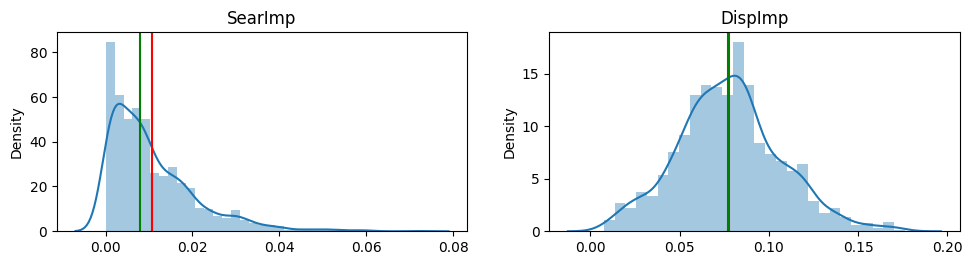

In [124]:
f = plt.figure(figsize=(18,15))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)

- red line: mean
- green line: median

# Decompose sales to media channels' contribution

In [125]:
adstock_params = mmm['adstock_params']
beta = mmm['beta']
tau = mmm['tau']
media_vars = mmm['media_vars']
ctrl_vars = mmm['ctrl_vars']
num_media = len(media_vars)
num_ctrl = len(ctrl_vars)

# Each media channel's contribution = total sales - sales upon removal the channel
# decompose sales to media contribution

In [126]:
def mmm_decompose_contrib(mmm, df, original_sales=df['sales']):
    # adstock params
    adstock_params = mmm['adstock_params']
    # coefficients, intercept
    beta, tau = mmm['beta'], mmm['tau']
    # variables
    media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
    num_media, num_ctrl = len(media_vars), len(ctrl_vars)
    
    # X_media2: adstocked, mean-centered media variables + 1
    X_media2 = adstock_transform(df, media_vars, adstock_params)
    X_media2, sc_mmm2 = mean_center_trandform(X_media2, media_vars)
    X_media2 = X_media2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = mean_center_trandform(df[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = mean_center_trandform(df, ['sales'])
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    
    # X2 <- media variables + ctrl variable
    X2 = pd.concat([X_media2, X_ctrl2], axis=1)

    # 1. compute each media/control factor: 
    # log-log model: log(sales) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: sales = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^tau
    
    factor_df = pd.DataFrame(columns=media_vars+ctrl_vars+['intercept'])
    for i in range(num_media):
        colname = media_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta[num_media+i]
    factor_df['intercept'] = np.exp(tau)

    # 2. calculate the product of all factors -> y_pred
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. calculate each media factor's contribution
    # media contribution = total volume – volume upon removal of the media factor
    mc_df = pd.DataFrame(columns=media_vars+['baseline'])
    for col in media_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df['baseline']
    mc_df['y_true2'] = factor_df['y_true2']

    # 4. scale contribution
    # predicted total media contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[media_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in media_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original sales
    mc_df['sales'] = original_sales
    for col in media_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['sales']/mc_df['y_true2']
    
    print('rmse (log-log model): ', 
         mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
    print('mape (multiplicative model): ', 
         mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

In [127]:
# calculate media contribution percentage
def calc_media_contrib_pct(mc_df, media_vars=mdip_cols, sales_col='sales', period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col]).mean()
    else:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col])[-period:].mean()
    for m in media_vars:
        s += mc_pct[m]
    for m in media_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2

In [128]:
mc_df = mmm_decompose_contrib(mmm, df, original_sales=df['sales'])

rmse (log-log model):  0.26690322319666476
mape (multiplicative model):  22.66725532157056


In [129]:
adstock_params = mmm['adstock_params']

In [130]:
mc_pct, mc_pct2 = calc_media_contrib_pct(mc_df, period=52)

In [95]:
# mc_df.to_csv('mc_df1.csv', index=False)

In [131]:
import json

def save_json(data, file_name):
    with open(file_name, 'w') as fp:
        json.dump(data, fp)

def load_json(file_name):
    with open(file_name, 'r') as fp:
        data = json.load(fp)
    return data

In [132]:
save_json(adstock_params, 'adstock_params1.json')
pd.concat([
    pd.DataFrame.from_dict(mc_pct, orient='index', columns=['mc_pct']),
    pd.DataFrame.from_dict(mc_pct2, orient='index', columns=['mc_pct2'])
], axis=1).to_csv('mc_pct_df1.csv')

In [133]:
mc_pct2

{'SearImp': 0.4054782709147213, 'DispImp': 0.5945217290852787}

These two media spending:
- <font color='blue'>Search Impressions</font> 'Total paid search impressions delivered daily'
- <font color='green'>Display impressions</font> 'Total paid display impressions delivered daily'
Contribute to the productId 300 sales.

### We suggest the stakeholders to increase the display impressions for this product.
### This is the key driver for sales

# 3) Diminishing Return Model

Goal: for each channel, find the relationship (fit a Hill function) between spending and contribution, so that ROAS and marginal ROAS can be calculated

In [134]:
def create_hill_model_data(df, mc_df, adstock_params, media):
#     y = mc_df['mdip_'+media].values
    y = mc_df[media].values
    L, P, D = adstock_params[media]['L'], adstock_params[media]['P'], adstock_params[media]['D']
#     x = df['mdsp_'+media].values
    x = df[media].values
    x_adstocked = apply_adstock(x, L, P, D)
    # centralize
    mu_x, mu_y = x_adstocked.mean(), y.mean()
    sc = {'x': mu_x, 'y': mu_y}
    x = x_adstocked/mu_x
    y = y/mu_y

    model_data = {
        'N': len(y),
        'y': y,
        'X': x
    }
    return model_data, sc

In [135]:
model_code3 = '''
functions { // the Hill function
  real Hill(real t, real ec, real slope) {
  return 1 / (1 + (t / ec)^(-slope));
  }
}

data {
  int N;         // the total number of observations
  vector[N] y;   // y: vector of media contribution
  vector[N] X;   // X: vector of adstocked media spending
}

parameters {
  real noise_var;                   // residual variance
  real<lower=0> beta_hill;          // regression coefficient
  real<lower=0,upper=1> ec;         // ec50 and slope for Hill function of the media
  real<lower=0> slope;
}

transformed parameters {
  vector[N] mu;          // a vector of the mean response
  for (i in 1:N) {
    mu[i] <- beta_hill * Hill(X[i], ec, slope);
  }
}

model {
  slope ~ gamma(3, 1);
  ec ~ beta(2, 2);
  beta_hill ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01); 
  y ~ normal(mu, sqrt(noise_var));
}
'''

# pipeline for training one hill model for a media channel

In [136]:
def train_hill_model(df, mc_df, adstock_params, media, sm):
    '''
    params:
    df: original data
    mc_df: media contribution df derived from MMM
    adstock_params: adstock parameter dict output by MMM
    media: 'dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem'
    sm: stan model object    
    returns:
    a dict of model data, scaler, parameters
    '''
    data, sc = create_hill_model_data(df, mc_df, adstock_params, media)
    fit = sm.sampling(data=data, iter=2000, chains=4)
    fit_result = fit.extract()
    hill_model = {
        'beta_hill_list': fit_result['beta_hill'].tolist(),
        'ec_list': fit_result['ec'].tolist(),
        'slope_list': fit_result['slope'].tolist(),
        'sc': sc,
        'data': {
            'X': data['X'].tolist(),
            'y': data['y'].tolist(),
        }
    }
    return hill_model

# extract params by mean or median
# almost no difference, choose either one
def extract_hill_model_params(hill_model, method='mean'):
    if method=='mean':
        hill_model_params = {
            'beta_hill': np.mean(hill_model['beta_hill_list']), 
            'ec': np.mean(hill_model['ec_list']), 
            'slope': np.mean(hill_model['slope_list'])
        }
    elif method=='median':
        hill_model_params = {
            'beta_hill': np.median(hill_model['beta_hill_list']), 
            'ec': np.median(hill_model['ec_list']), 
            'slope': np.median(hill_model['slope_list'])
        }
    return hill_model_params

def hill_model_predict(hill_model_params, x):
    beta_hill, ec, slope = hill_model_params['beta_hill'], hill_model_params['ec'], hill_model_params['slope']
    y_pred = beta_hill * hill_transform(x, ec, slope)
    return y_pred

def evaluate_hill_model(hill_model, hill_model_params):
    x = np.asarray(hill_model['data']['X'])
    y_true = np.asarray(hill_model['data']['y']) * hill_model['sc']['y']
    y_pred = hill_model_predict(hill_model_params, x) * hill_model['sc']['y']
    print('mape on original data: ', 
         mean_absolute_percentage_error(y_true, y_pred))
    return y_true, y_pred

# Train hill models for all media channels

In [137]:
sm3 = pystan.StanModel(model_code=model_code3, verbose=True)

DIAGNOSTIC(S) FROM PARSER:
Info: assignment operator <- deprecated in the Stan language; use = instead.

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_163d8eb7d78ea46a0808bff1efeebcfb NOW.
INFO:pystan:OS: darwin, Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:59:23) 
[Clang 11.1.0 ], Cython 3.0.8


Compiling /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.pyx because it changed.
[1/1] Cythonizing /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.pyx


INFO:root:building 'stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660' extension
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/var
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/var/folders
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/var/folders/3y
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T
INFO:root:creating /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43
INFO:root:x86_64-apple-darwin13.4.0-clang -fno-strict-aliasing -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O3 -Wall -Wstrict-prototypes -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:344:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr.hpp:46:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/arr/functor/integrate_ode_rk45.hpp:17:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1287:
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan_fit.hpp:841:12: warning: 'auto_ptr<stan::io::var_context>' is deprecated [-Wdeprecated-declarations]
      std::auto_ptr<stan::io::var_context> init_context_ptr;
           ^
/Users/dportelacassab/anaconda3/envs/myenv/bin/../include/c++/v1/__memory/auto_ptr.h:30:28: note: 'auto_ptr<stan::io::var_context>' has been explicitly marked deprecated here
class _LIBCPP_TEMPLATE_VIS _LIBCPP_DEPRECATED_IN_CXX11 auto_ptr
                           ^
/Users/dportelacassab/anaconda3/envs/myenv/bin/../include/c++/v1/__config:862:41: note: expanded from macro '_LIBCPP_DEPRECATED_IN_CXX11'
#    define _LIBCPP_DEPRECATED_IN_CXX11 _LIBCPP_DEPRECATED
                                        ^
/Users/dportelacassab/anaconda3/envs/myenv/bin/../include/c++/v1/_

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/AssignEvaluator.h:804:3: note: in instantiation of function template specialization 'Eigen::internal::call_assignment_no_alias<Eigen::Matrix<double, -1, 1, 0>, Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double>, const Eigen::Matrix<double, -1, 1, 0>, const Eigen::CwiseBinaryOp<Eigen::internal::scalar_difference_op<double>, const Eigen::Matrix<double, -1, 1, 0>, const Eigen::Matrix<double, -1, 1, 0>>>, Eigen::internal::add_assign_op<double, double>>' requested here
  call_assignment_no_alias(dst, src, func);
  ^
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/src/Core/CwiseBinaryOp.h:177:3: note: in instantiation of function template specialization 'Eigen::internal::call_assignment<Eigen::Matrix<double, -1, 1, 0>, Eigen::CwiseBinaryOp<Eigen::internal::scalar_product_op<double>, 

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1287:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan_fit.hpp:15:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/additive_combine.hpp:27:
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:140:20: warning: overlapping comparisons always evaluate to false [-Wtautological-overlap-compare]
        if(_x <= 0 && _x != 0) {
           ~~~~~~~~^~~~~~~~~~
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0/boost/random/linear_congruential.hpp:393:11: note: in instantiation of member function 'boost::random::linear_con

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

In file included from /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/stanfit4anon_model_163d8eb7d78ea46a0808bff1efeebcfb_1232574353838737660.cpp:1286:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/py_var_context.hpp:12:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/src/stan/io/dump.hpp:6:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat.hpp:9:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/meta/as_array_or_scalar.hpp:4:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3/Eigen/Dense:1:
In file included from /Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pystan/stan/lib/stan_m

189 warnings generated.
INFO:root:x86_64-apple-darwin13.4.0-clang++ -bundle -undefined dynamic_lookup -Wl,-pie -Wl,-headerpad_max_install_names -Wl,-dead_strip_dylibs -Wl,-rpath,/Users/dportelacassab/anaconda3/envs/myenv/lib -L/Users/dportelacassab/anaconda3/envs/myenv/lib -flto -Wl,-export_dynamic -Wl,-pie -Wl,-headerpad_max_install_names -Wl,-dead_strip_dylibs -Wl,-rpath,/Users/dportelacassab/anaconda3/envs/myenv/lib -L/Users/dportelacassab/anaconda3/envs/myenv/lib -Wl,-pie -Wl,-headerpad_max_install_names -Wl,-dead_strip_dylibs -Wl,-rpath,/Users/dportelacassab/anaconda3/envs/myenv/lib -L/Users/dportelacassab/anaconda3/envs/myenv/lib -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O2 -pipe -isystem /Users/dportelacassab/anaconda3/envs/myenv/include -D_FORTIFY_SOURCE=2 -isystem /Users/dportelacassab/anaconda3/envs/myenv/include /var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pystan_os3yho43/var/folders/3y/r2qdry316rbd57grh_f37fph0000gn/T/pys

In [138]:
mc_pct2

{'SearImp': 0.4054782709147213, 'DispImp': 0.5945217290852787}

In [139]:
mc_df.head()

SearImp   DispImp    baseline   y_true2   mc_pred   mc_true  mc_delta  \
0  32.868783  0.000485  197.130731  2.012982  0.000357  0.287675 -0.287318   
1   3.613078  0.000141  172.386781  1.775152  0.002395  0.036443 -0.034048   
2  17.275242  0.001875  190.722883  1.916088  0.006199  0.159156 -0.152957   
3   2.878761  0.000655  183.120584  1.819194  0.007644  0.028162 -0.020518   
4  47.514586  0.014060  224.471354  2.197962  0.010429  0.384067 -0.373637   

   sales  
0    230  
1    176  
2    208  
3    186  
4    272

In [140]:
hill_models = {}
to_train = ['SearImp','DispImp']

In [141]:
for media in to_train:
    print('training for media: ', media)
    hill_model = train_hill_model(df, mc_df, adstock_params, media, sm3)
    print("trained for media: ", media)
    hill_models[media] = hill_model

training for media:  SearImp


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in 'unknown file name' at line 33)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

IOStream.flush timed out
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in 'unknown file name' at line 33)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may 


Gradient evaluation took 0.00071 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.1 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000433 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.33 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 33)


Gradient evaluation took 0.000297 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.97 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000214 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.14 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmu

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 33)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 33)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.564113 seconds (Warm-up)
               0.421059 seconds (Sampling)
               0.985172 seconds (Total)

Iteration: 1800 / 2000 [ 90%]  (Sampling)


INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection


Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.563499 seconds (Warm-up)
               0.494217 seconds (Sampling)
               1.05772 seconds (Total)

Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.550085 seconds (Warm-up)
               0.547691 seconds (Sampling)
               1.09778 seconds (Total)

Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 0.59272 seconds (Warm-up)
               0.541921 seconds (Sampling)
               1.13464 seconds (Total)



trained for media:  SearImp
training for media:  DispImp


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in 'unknown file name' at line 33)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

IOStream.flush timed out
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in 'unknown file name' at line 33)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may 

Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 33)


Gradient evaluation took 0.000371 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.71 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 33)


Gradient evaluation took 0.000347 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.47 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000251 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.51 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 33)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is nan, but must be > 0!  (in 'unknown file name' at line 33)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of 

Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1400 

INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection
INFO:py4j.clientserver:Closing down clientserver connection


trained for media:  DispImp


### extract params by mean

In [142]:
hill_model_params_mean, hill_model_params_med = {}, {}
for md in list(hill_models.keys()):
    print("extracting " + md)
    hill_model = hill_models[md]
    params1 = extract_hill_model_params(hill_model, method='mean')
    params1['sc'] = hill_model['sc']
    hill_model_params_mean[md] = params1
#     params2 = extract_hill_model_params(hill_model, method='median')
#     params2['sc'] = hill_model['sc']
#     hill_model_params_med[md] = params2
# save_json(hill_model_params_med, 'hill_model_params_med.json')
# save_json(hill_model_params_mean, 'hill_model_params_mean.json')

extracting SearImp
extracting DispImp


### evaluate model params extracted by mean

In [143]:
for md in list(hill_models.keys()):
    print('evaluating media: ', md)
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    _ = evaluate_hill_model(hill_model, hill_model_params)

evaluating media:  SearImp
mape on original data:  nan
evaluating media:  DispImp
mape on original data:  729.734161061297


/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


mape looks just way too high.

# Plot fitted hill function

/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


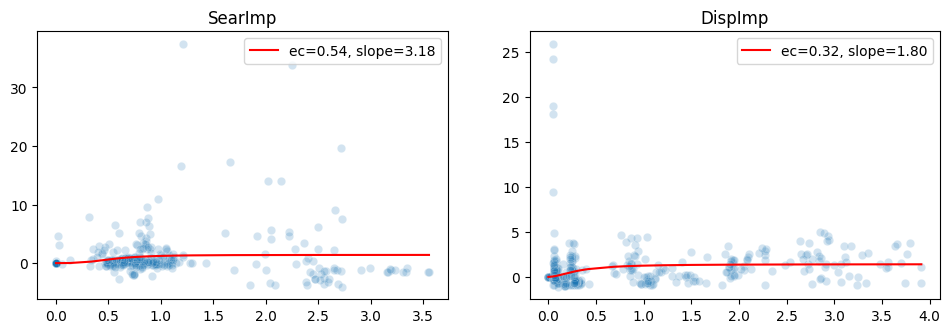

In [144]:
f = plt.figure(figsize=(18,16))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    hm = hill_models[md]
    hmp = hill_model_params_mean[md]
    x, y = hm['data']['X'], hm['data']['y']
    #mu_x, mu_y = hm['sc']['x'], hm['sc']['y']
    ec, slope = hmp['ec'], hmp['slope']
    x_sorted = np.array(sorted(x))
    y_fit = hill_model_predict(hmp, x_sorted)
    ax = sns.scatterplot(x=x, y=y, alpha=0.2)
    ax = sns.lineplot(x=x_sorted, y=y_fit, color='r', 
                 label='ec=%.2f, slope=%.2f'%(ec, slope))
    ax.set_title(md)

# Calculate overall ROAS and weekly ROAS
# - Overall ROAS = total contribution / total spending
# - Weekly ROAS = weekly contribution / weekly spending

In [145]:
# adstocked media spending
ms_df = pd.DataFrame()
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    x = np.array(hill_model['data']['X']) * hill_model['sc']['x']
    ms_df['mdsp_'+md] = x

In [120]:
# ms_df.to_csv('ms_df1.csv', index=False)

ROAS for the m-th media is calculated as

$$ROAS_m = \frac{ \sum_{t_0 \leq t \leq t_1 + L - 1} \hat{Y}_t^m \left( x_{t-L+1,m} , ... , x_{t,m} ; \phi \right) - \hat{Y}_t^m \left( \tilde{x}_{t-L+1,m} , ... , \tilde{x}_{t,m} ; \phi \right) }{\sum_{t_0\leq t\leq t_1} x_{t,m}}$$

# calc overall ROAS of a given period

In [146]:
def calc_roas(mc_df, ms_df, period=None):
    roas = {}
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for i in range(len(md_names)):
        md = md_names[i]
#         sp, mc = ms_df['mdsp_'+md], mc_df['mdip_'+md]
        sp, mc = ms_df['mdsp_'+md], mc_df[md]
        if period is None:
            md_roas = mc.sum()/sp.sum()
        else:
            md_roas = mc[-period:].sum()/sp[-period:].sum()
        roas[md] = md_roas
    return roas

In [147]:
# calc weekly ROAS
def calc_weekly_roas(mc_df, ms_df):
    weekly_roas = pd.DataFrame()
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for md in md_names:
#         weekly_roas[md] = mc_df['mdip_'+md]/ms_df['mdsp_'+md]
        weekly_roas[md] = mc_df[md]/ms_df['mdsp_'+md]
    weekly_roas.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return weekly_roas

In [148]:
roas_1y = calc_roas(mc_df, ms_df, period=52)
weekly_roas = calc_weekly_roas(mc_df, ms_df)
roas1y_df = pd.DataFrame(index=weekly_roas.columns.tolist())
roas1y_df['roas_mean'] = weekly_roas[-52:].apply(np.mean, axis=0)
roas1y_df['roas_median'] = weekly_roas[-52:].apply(np.median, axis=0)

/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



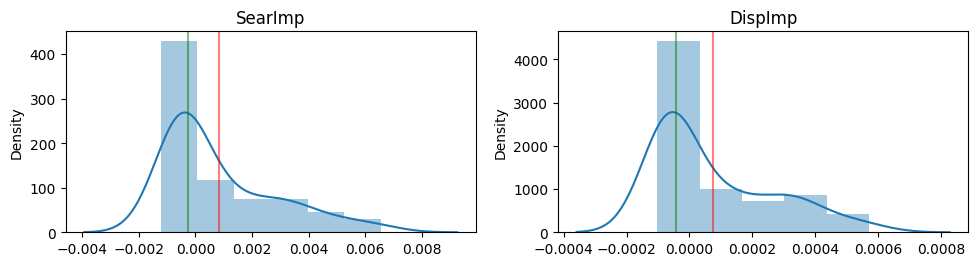

In [149]:
# # plot weekly ROAS distribution
# # median: green line, mean: red line
# f = plt.figure(figsize=(18,12))
# for i in range(len(weekly_roas.columns)):
#     md = weekly_roas.columns[i]
#     ax = f.add_subplot(4,3,i+1)
#     x = weekly_roas[md]
#     mean_x = np.mean(x)
#     median_x = np.median(x)
#     ax = sns.distplot(x)
#     ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
#     ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
#     ax.set(xlabel=None)
#     ax.set_title(md)

# plot weekly ROAS distribution of past 1 year
# median: green line, mean: red line
f = plt.figure(figsize=(18,12))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:]
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)

## ROAS is the change in revenue (or sales) per dollar spent on the medium

## mROAS for the m-th medium is the additional revenue generated by one-unit increase in spend, usually from the current spent level

The calculation of mROAS. A simple way is to apply multiplicative change of, for example, 1%, to the media spend in the selected period.

$$mROAS_m = \frac{ \sum_{t_0 \leq t \leq t_1 + L - 1} \hat{Y}_t^m \left( \tilde{\tilde{x}}_{t-L+1,m} , ... , \tilde{\tilde{x}}_{t,m} ; \phi \right) - \hat{Y}_t^m \left( x_{t-L+1,m} , ... , x_{t,m} ; \phi \right) }{0.01 \sum_{t_0\leq t\leq t_1} x_{t,m}}$$

# Calculate mROAS
# 1. Current spending level (cur_sp) is represented by mean or median of weekly spending.    
# Next spending level (next_sp) is increasing cur_sp by 1%.
# 2. Plug cur_sp and next_sp into the Hill function:    
# Current media contribution: cur_mc = Hill(cur_sp)    
# Next-level media contribution next_mc = Hill(next_sp)    
# 3. mROAS = (next_mc - cur_mc) / (0.01 * cur_sp)

In [150]:
def calc_mroas(hill_model, hill_model_params, period=52):
    '''
    calculate mROAS for a media
    params:
    hill_model: a dict containing model data and scaling factor
    hill_model_params: a dict containing beta_hill, ec, slope
    period: in weeks, the period used to calculate ROAS and mROAS. 52 is last one year.
    return:
    mROAS value
    '''
    mu_x, mu_y = hill_model['sc']['x'], hill_model['sc']['y']
    # get current media spending level over the period specified
    cur_sp = np.asarray(hill_model['data']['X'])
    if period is not None:
        cur_sp = cur_sp[-period:]
#     cur_mc = sum(hill_model_predict(hill_model_params, cur_sp) * mu_y)
    cur_mc = (hill_model_predict(hill_model_params, cur_sp) * mu_y).sum()
    # next spending level: increase by 1%
    next_sp = cur_sp * 1.01
    # media contribution under next spending level
#     next_mc = sum(hill_model_predict(hill_model_params, next_sp) * mu_y)
    next_mc = (hill_model_predict(hill_model_params, next_sp) * mu_y).sum()
    
    # mROAS
    delta_mc = next_mc - cur_mc
#     delta_sp = sum(next_sp * mu_x) - sum(cur_sp * mu_x)
    delta_sp = (next_sp * mu_x).sum() - (cur_sp * mu_x).sum()
    mroas = delta_mc/delta_sp
    return mroas

# calc mROAS of recent 1 year

In [151]:
mroas_1y = {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    mroas_1y[md] = calc_mroas(hill_model, hill_model_params, period=52)

In [152]:
roas1y_df = pd.concat([
    roas1y_df[['roas_mean', 'roas_median']],
    pd.DataFrame.from_dict(mroas_1y, orient='index', columns=['mroas']),
    pd.DataFrame.from_dict(roas_1y, orient='index', columns=['roas_avg'])
], axis=1)

In [153]:
roas1y_df.to_csv('roas1y_df1.csv')

In [154]:
roas1y_df

roas_mean  roas_median     mroas  roas_avg
SearImp   0.000828    -0.000269  0.000262  0.000209
DispImp   0.000074    -0.000043  0.000088  0.000062

# **ROAS & mROAS**    
# 'roas_avg': overall ROAS = total contribution / total spending    
# 'roas_mean': mean of weekly ROAS    
# 'roas_median': median of weekly ROAS    
# 'mroas': mROAS calculated based on increasing current spending level by 1%   

# Results & Marketing Budget Optimization

In [156]:
# Image(url="FeatureImportance.png", width=300, height=10)
# https://www.linkedin.com/pulse/lightweight-marketing-mix-modeling-mmm-using-python-jared-randall/

24/02/22 05:33:37 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1366666 ms exceeds timeout 120000 ms
24/02/22 05:33:38 WARN SparkContext: Killing executors is not supported by current scheduler.
24/02/22 05:33:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.

24/02/22 05:33:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:34:03 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:35:21 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:35:31 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:35:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:35:51 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:36:01 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:43:42 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 05:43:52 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:44:02 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

	at org.apache.spark.rpc.netty.NettyRpcCallContext.reply(NettyRpcCallContext.scala:32)
	at org.apache.spark.rpc.netty.RpcEndpointVerifier$$anonfun$receiveAndReply$1.applyOrElse(RpcEndpointVerifier.scala:31)
	... 8 more
24/02/22 05:44:12 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.r

	at org.apache.spark.rpc.netty.NettyRpcCallContext.reply(NettyRpcCallContext.scala:32)
	at org.apache.spark.rpc.netty.RpcEndpointVerifier$$anonfun$receiveAndReply$1.applyOrElse(RpcEndpointVerifier.scala:31)
	... 8 more
24/02/22 05:44:12 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockM

24/02/22 05:45:05 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:45:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:45:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 05:45:44 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 05:45:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:03:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:03:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:03:33 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:03:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:04:03 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:04:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:04:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:04:33 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:04:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:04:53 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 06:05:03 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:05:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:05:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:05:33 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:05:43 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:05:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:06:03 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 06:06:13 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:06:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:06:33 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:06:43 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 06:06:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:16:44 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 06:16:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:17:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:17:24 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 06:17:34 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

24/02/22 06:17:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:17:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:18:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:18:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:18:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:18:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:18:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:18:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:19:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:19:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:19:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

24/02/22 06:19:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 54781)
Traceback (most recent call last):
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/Users/dportelacassab/anaconda3/envs/myenv/lib/python3.7/site-packag